# Heart segmentation - ejection fraction

Measure the ejection fraction: the proportion of blood ejected from the left ventricle during each stroke.
Using a 4D cardiac time series, determine if a patient is likely to have heart disease.

Code has been updated to support imageio==2.19.2.

## Data
This dataset is drawn from the [Sunnybrook Cardiac Atlas Project](http://www.cardiacatlas.org/studies/sunnybrook-cardiac-data/). It has been de-identified and used as training data in a number of different competitions. This particular subject is a 27-year old male and was diagnosed with "heart failure without infarct". It may be found in the dataset under the ID of SCD0002001, as well as SC-HF-NI-15.  The series description for the included scans was: 1.528_???_-x_-y_256_256_???. They have been modified slightly from the original.

## Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import imageio
import scipy.ndimage as ndi
print(imageio.__version__)

2.19.2


In [2]:
plt.rcParams['figure.figsize'] = (16, 8)
DATA_PATH = "sunnybrook-cardiac-mr/"

## Load Data

### Metadata

Metadata of medical images include:

- Patient demographics: name, age, sex, clinical information
- Acquisition information: image shape, sampling rates, data type, modality (such as X-Ray, CT or MRI)

In [3]:
#Test Img
testimg = DATA_PATH + '/SCD2001_006/SCD2001_MR_117.dcm'

# Load "chest-220.dcm"
im = imageio.v2.imread(testimg)

# Print image attributes
print('Image type:', type(im))
print('Shape of image array:', im.shape)

# Print the available metadata fields
print(im.meta.keys())

Image type: <class 'imageio.core.util.Array'>
Shape of image array: (256, 256)
odict_keys(['TransferSyntaxUID', 'SOPClassUID', 'SOPInstanceUID', 'StudyDate', 'SeriesDate', 'AcquisitionDate', 'ContentDate', 'StudyTime', 'SeriesTime', 'AcquisitionTime', 'ContentTime', 'Modality', 'Manufacturer', 'StudyDescription', 'SeriesDescription', 'PatientName', 'PatientID', 'PatientBirthDate', 'PatientSex', 'SliceSpacing', 'StudyInstanceUID', 'SeriesInstanceUID', 'SeriesNumber', 'AcquisitionNumber', 'InstanceNumber', 'ImagePositionPatient', 'ImageOrientationPatient', 'SamplesPerPixel', 'Rows', 'Columns', 'PixelSpacing', 'BitsAllocated', 'BitsStored', 'HighBit', 'PixelRepresentation', 'PixelData', 'shape', 'sampling'])


## Heart Segmentation

Image of the heart pumping blood from a single slice of the volume (im).

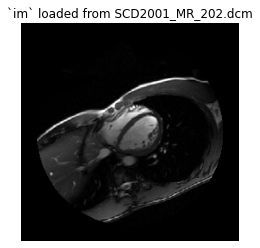

In [4]:
# Draw the image in grayscale
plt.imshow(im, cmap='gray')

# Render the image
plt.axis('off')
plt.title(f"`im` loaded from SCD2001_MR_202.dcm")
plt.show()

In [5]:
def format_and_render_plot():
    '''Custom function to simplify common formatting operations. Operations include: 
    1. Turning off axis grids.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.'''
    fig = plt.gcf()
    for ax in fig.axes:
        ax.axis('off')    
    plt.tight_layout()
    plt.show()

### Label objects

1. Filter and mask the image
2. Label each object with ndi.label()

Num. Labels: 26


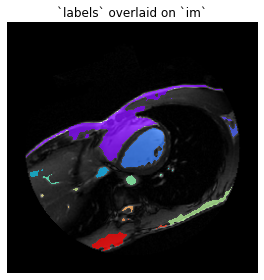

In [6]:
# Smooth intensity values
im_filt = ndi.median_filter(im, size=3)

# Select high-intensity pixels
mask_start = np.where(im_filt>60, 1, 0)
mask = ndi.binary_closing(mask_start)

# Label the objects in "mask"
labels, nlabels = ndi.label(mask)
print('Num. Labels:', nlabels)

# Create a `labels` overlay
overlay = np.where(labels>0, labels, np.nan)

# Use imshow to plot the overlay
plt.imshow(im, cmap='gray')
plt.imshow(overlay, cmap='rainbow', alpha=0.75)
plt.title(f"`labels` overlaid on `im`")
format_and_render_plot()

### Select objects

Find the label value for the centrally-located left ventricle, and create a mask for it

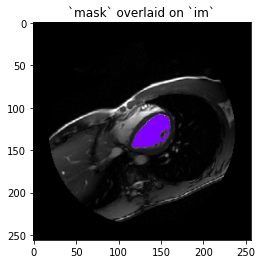

In [7]:
# Label the image "mask"
labels, nlabels = ndi.label(mask)

# Select left ventricle pixels
lv_val = labels[128, 128]
lv_mask = np.where(labels == lv_val, 1, np.nan)

# Overlay selected label
plt.imshow(im, cmap='gray')
plt.imshow(lv_mask, cmap='rainbow')
plt.title(f"`mask` overlaid on `im`")
plt.show()

### Extract objects

Extracting the centrally-located left ventricle from the original image by eliminating unrelated pixels. <br>
We achieve this using ndi.find_objects() to create a new image containing with only the left ventricle.

Number of objects: 1
Indices for first box: (slice(107, 149, None), slice(116, 162, None))


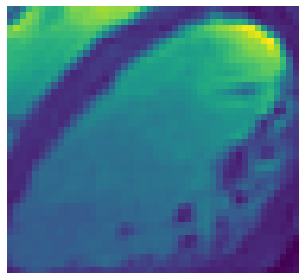

In [8]:
# Create left ventricle mask
labels, nlabels = ndi.label(mask)
lv_val = labels[128, 128]
lv_mask = np.where(labels == lv_val, 1, 0)

# Find bounding box of left ventricle
bboxes = ndi.find_objects(lv_mask)
print('Number of objects:', len(bboxes))
print('Indices for first box:', bboxes[0])

# Crop to the left ventricle (index 0)
im_lv = im[bboxes[0]]

# Plot the cropped image
plt.imshow(im_lv)
format_and_render_plot()

## Measuring Intensity

In [9]:
## Stack images into a volume
vol = imageio.volread(DATA_PATH + '/SCD2001_006/', 'DICOM')

Reading DICOM (examining files): 1/21 files (4.8%21/21 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 21/21  (100.0%)


In [14]:
# Smooth intensity values
vol_filt = ndi.median_filter(vol, size=3)

# Select high-intensity pixels
mask_start = np.where(vol_filt>60, 1, 0)
mask = ndi.binary_closing(mask_start)

# Label the objects in "mask"
labels, nlabels = ndi.label(mask)

### Measure Variance

Now, we calculate the intensity variance of vol with respect to different pixel sets. <br>
Labels: label 1 is the left ventricle and label 2 is a circular sample of tissue.

In [18]:
# Variance for all pixels
var_all = ndi.variance(vol)
print('All pixels:', var_all)

# Variance for labeled pixels
var_labels = ndi.variance(vol, labels)
print('Labeled pixels:', var_labels)

# Variance for each object
var_objects = ndi.variance(vol, labels, index=[1,2])
print('Left ventricle:', var_objects[0])
print('Other tissue:', var_objects[1])

All pixels: 1024.5268017215453
Labeled pixels: 2233.1445409307903
Left ventricle: 2525.8801734035246
Other tissue: 72.51552636517167


"All pixels" has the lowest variance because it has many pixels with 0 values.

###  Separate histograms
A poor tissue segmentation includes multiple tissue types, leading to a wide distribution of intensity values and more variance.
On the other hand, a perfectly segmented left ventricle would contain only blood-related pixels, so the histogram of the segmented values should be roughly bell-shaped.

Let's compare the intensity distributions within vol for the listed sets of pixels using ndi.histogram.

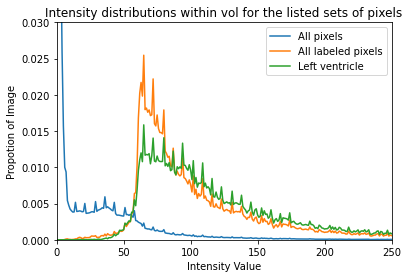

In [19]:
# Create histograms for selected pixels
hist1 = ndi.histogram(vol, min=0, max=255, bins=256)
hist2 = ndi.histogram(vol, 0, 255, 256, labels=labels)
hist3 = ndi.histogram(vol, 0, 255, 256, labels=labels, index=1)

# Plot the histogram density
plt.plot(hist1 / hist1.sum(), label='All pixels')
plt.plot(hist2 / hist2.sum(), label='All labeled pixels')
plt.plot(hist3 / hist3.sum(), label='Left ventricle')
plt.ylim(0, 0.03)
plt.xlim(0, 250)
plt.legend()
plt.title("Intensity distributions within vol for the listed sets of pixels")
plt.xlabel('Intensity Value')
plt.ylabel('Propotion of Image')
plt.show()

The left ventricle segmentation is more normally distributed than the other sets of pixels.

### Calculate distance

Next, let's calculate the distance from each pixel to a given point, usually the nearest background pixel to determine which points in the object are more interior and which are closer to edges. <br>
We will use the Euclidian distance transform on the left ventricle object in labels.

Max distance (mm): 0.0
Max location: (0, 0, 0)


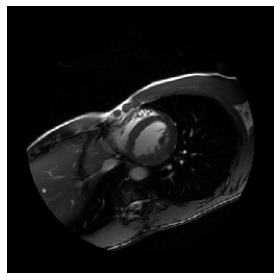

In [26]:
# Calculate left ventricle distances
lv = np.where(labels == 1, 1, 0)
dists = ndi.distance_transform_edt(lv, sampling = vol.meta['sampling'])

# Report on distances
print('Max distance (mm):', ndi.maximum(dists))
print('Max location:', ndi.maximum_position(dists))

# Plot overlay of distances
overlay = np.where(dists[5] > 0, dists[5], np.nan)
plt.imshow(vol[5], cmap='gray')
plt.imshow(overlay, cmap='hot')
format_and_render_plot()